In [1]:
import random
import numpy as np
import matplotlib
import numba
import time
import multiprocessing as mp
from numba import jit, prange
from numba import config, njit, threading_layer
from matplotlib import pyplot as plt

In [2]:
#random.seed(1235)
#Demand function from Klein (2020)
@njit
def PD_rewards(p1,p2):
    x = np.array(
            [[(3,3), (0,5)],
            [(5,0), (1,1)]]
             )
    val_p1, val_p2 = x[p1,p2]
    
    return val_p1, val_p2
        

In [3]:

@njit
def master_q_player(prices, Q, epsilon, p2,t):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[t,:,p2]))
    return p3

In [4]:
@njit
def npc_player(options, q_table, epsilon, prev, time):
    if prev[time-1]==0 and prev[time]==0:
        npc_choice = 0
    else:
        npc_choice = 1
    return npc_choice

In [5]:
@njit
def regular_update(Q, prev, alpha, delta, prices, indic):
    # if indic == 1: 
    #     p1 = prices[prev[0,0]]
    #     p2 = prices[prev[1,0]]
    #     p22 = prices[prev[1,1]]
    #     pe1 = Q[prev[0,0],prev[1,0]]
    #     ne1 = p1*PD_rewards(p1,p2) + delta* p1*PD_rewards(p1,p22) + delta**2 * Q[np.argmax(Q[:,prev[1,1]]),prev[1,1]]
    #     Q[prev[0,0], prev[1,0]] = (1-alpha) * pe1 + alpha * ne1
    #     #print('GAME player 1 ne and pe', ne1, pe1)
    # else: 
        p1 = prev[1,0]
        p2 = prev[0,0]
        p22 = prev[0,1]
        pe2 = Q[prev[1,0],prev[0,0]]
        ne2 = p1*PD_rewards(p1,p2)[1] + delta* p1*PD_rewards(p1,p22)[1] + delta**2 * Q[np.argmax(Q[:,prev[0,1]]),prev[0,1]]
        Q[prev[1,0], prev[0,0]] = (1-alpha) * pe2 + alpha * ne2

@njit
def simple_Q_learner(prices, Q, epsilon, p2):
    if random.uniform(0,1) < epsilon:
        p3 = int(np.random.choice(len(prices)))
        #print('now its random', epsilon)
    else:
        #p3, pyt = np.unravel_index(np.argmax(Q),Q.shape)
        p3 = int(np.argmax(Q[:,p2]))
    return p3

In [6]:

@njit
def update(Q, prev, alpha, delta, prices, Current_t, previous_t, time, interval):
        my_old_price = prev[0,0]
        their_old_price = prev[1,0]
        their_new_choice = prev[1,1]
        intervals = np.shape(Q)[0]
        
        # Current_t = numba.int64(np.floor(time/interval_size))
        # previous_t = numba.int64(np.floor((time-1)/interval_size))
                
        #print('indices',prev[0,0],prev[1,0],prev_time)
        #print('prices', my_old_price, their_new_choice, their_old_price)
        prev_q_est = Q[previous_t, prev[0,0],prev[1,0]]
        #print('PD_reward', PD_rewards(my_old_price,their_old_price))
        #print('argmax i Q', Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]])
        #print("PREV", prev[0,1])
        
        
        
        new_q_est = PD_rewards(my_old_price,their_old_price)[0] + delta* PD_rewards(my_old_price,their_new_choice)[0] + delta ** 2 * Q[Current_t, np.argmax(Q[Current_t,:,prev[1,1]]),prev[1,1]]
        #print("New Q est", new_q_est)
        prev_interval = max(0,Current_t-1)
        next_interval = min(intervals-1, Current_t+1)
        
        #print("operation",(time/interval) - Current_t)
        if (time/interval) - Current_t < 0.5:
                prev_w = 0.5 - abs((time/interval) - prev_interval )
                curr_w = 1-prev_w
                Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])
        else:
                next_w = 0.5 - abs((time/interval) - next_interval) 
                curr_w = 1-next_w
                Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]])

        #curr_w = 1-prev_w
        #Q[Current_t, prev[0,0], prev[1,0]] = (1-alpha) * prev_q_est + alpha * (curr_w * new_q_est + next_w * Q[next_interval, prev[0,0], prev[1,0]] + prev_w * Q[prev_interval, prev[0,0], prev[1,0]])

In [38]:
@njit
def PD_game(q_table, options, periods, alpha, theta, delta):
    a = len(options)
    Simple_Q_Table = np.zeros((a, a))
    interval_size = periods/15
    print("interval",interval_size)
    prev_choices = np.zeros((2,2), dtype=numba.int64)
    reward_arr = np.zeros(int(periods-2))
    reward_arr_p2 = np.zeros(int(periods-2))
    all_choices1 =np.zeros(int(periods/2)-1)
    all_choices2 =np.zeros(int(periods/2)-1)
    i_counter = 0
    j_counter = 0
    t=3
    if np.shape(q_table) != (15,a,a):
        print("Wrong dimensions")
    else:
        for t in range(t, periods+1):
        
            epsilon = (1-theta)**t
            if t % 2 != 0: 
                time_for_q = int(np.floor(t/interval_size))
                prev_time_for_q = int(np.floor((t-1)/interval_size))
                #print("TimeCHeck",time_for_q,time_for_q)
                #print('time for q', time_for_q, 'prev time for q', prev_time_for_q, "prev", prev_choices)
                update(q_table, prev_choices, alpha, delta, options, time_for_q, prev_time_for_q, t, interval_size)
                
                
                p_i = master_q_player(options, q_table, epsilon, prev_choices[1,1], time_for_q)
                
                prev_choices[0,0] = prev_choices[0,1]
                prev_choices[0,1] = p_i
                prev_choices[1,0] = prev_choices[1,1]
                all_choices1[i_counter] = (options[p_i])
                i_counter += 1
                #print('Spiller 1 tur: p:', prices[p_i],' p_j: ', prices[prev_p[1,1]],'iteration:', t,'Q_table: \n', Q_table)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
            else: 
                #In Case of Q opponent:
                regular_update(Simple_Q_Table, prev_choices, alpha, delta, options, 2)
                p_j = simple_Q_learner(options, Simple_Q_Table, epsilon, prev_choices[0,1])
                #a hard coded opponent: 
                #p_j= npc_player(options, q_table, 0, all_choices1,j_counter)
                
                
                prev_choices[1,0] = prev_choices[1,1]
                prev_choices[1,1] = p_j
                prev_choices[0,0] = prev_choices[0,1]
                all_choices2[j_counter] = (options[p_j])
                j_counter += 1
                #print('Spiller 2 tur: p:', prices[p_j], 'p_i', prices[prev_p[0,1]],' iteration: ', t,'Q_table2: \n', Q_table2)
                reward_arr[t-3], reward_arr_p2[t-3] = PD_rewards(prev_choices[0,1], prev_choices[1,1])
                #step_counter +=1
    return all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table





    
    

In [39]:
def many_games(prices, periods, alpha, theta, learners, delta, init_q):
    total_pro_arr = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_pro_arr2 = np.zeros((learners,periods-2),dtype=np.ndarray)
    total_opt_arr = np.zeros((learners, 49), dtype = np.ndarray)
    avg_profit = np.zeros(learners)
    avg_profit2 = np.zeros(learners)
    change_arr = np.zeros((1,25))
    change_arr2 = np.zeros((1,25))
    init_Q = init_q #np.zeros((10,2,2))
    for i in range(learners):
        print('run #',i+1 ,'of ', learners , 'runs')
        all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(init_Q, prices, periods, alpha, theta, delta)
        total_pro_arr[i] = reward_arr
        total_pro_arr2[i] = reward_arr_p2
        #total_opt_arr[i] = arr_opt_i
        avg_profit[i] = np.mean(reward_arr[-10000:])
        avg_profit2[i] = np.mean(reward_arr_p2[-10000:])
        init_Q = q_table
        
    return total_pro_arr, total_pro_arr2, avg_profit, avg_profit2, init_Q

In [9]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q = many_games(options, 100000, 0.3, 0.0000922, 50 ,0.95, init_Q)
final_Q

run # 1 of  50 runs
interval 6666.666666666667
run # 2 of  50 runs
interval 6666.666666666667
run # 3 of  50 runs
interval 6666.666666666667
run # 4 of  50 runs
interval 6666.666666666667
run # 5 of  50 runs
interval 6666.666666666667
run # 6 of  50 runs
interval 6666.666666666667
run # 7 of  50 runs
interval 6666.666666666667
run # 8 of  50 runs
interval 6666.666666666667
run # 9 of  50 runs
interval 6666.666666666667
run # 10 of  50 runs
interval 6666.666666666667
run # 11 of  50 runs
interval 6666.666666666667
run # 12 of  50 runs
interval 6666.666666666667
run # 13 of  50 runs
interval 6666.666666666667
run # 14 of  50 runs
interval 6666.666666666667
run # 15 of  50 runs
interval 6666.666666666667
run # 16 of  50 runs
interval 6666.666666666667
run # 17 of  50 runs
interval 6666.666666666667
run # 18 of  50 runs
interval 6666.666666666667
run # 19 of  50 runs
interval 6666.666666666667
run # 20 of  50 runs
interval 6666.666666666667
run # 21 of  50 runs
interval 6666.666666666667
r

array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan,  0.]],

       [[nan, nan],
        [nan,  0.]],

       [[nan, nan],
        [nan,  0.]],

       [[nan, nan],
        [nan,  0.]],

       [[nan, nan],
        [nan,  0.]]])

In [10]:
def moving_avg(fst_arr, snd_arr, window_size):

    moving_averages = []
    moving_averages2 = []
    i = 0
    while i < len(fst_arr) - window_size + 1:
    
        # Calculate the average of current window
        window_average = np.sum(fst_arr[
        i:i+window_size]) / window_size
        window_average2 = np.sum(snd_arr[
        i:i+window_size]) / window_size
        
        # Store the average of current
        # window in moving average list
        moving_averages.append(window_average)
        moving_averages2.append(window_average2)

        
        # Shift window to right by one position
        i += 1
    return moving_averages, moving_averages2

def prof_means(prof_arr1, prof_arr2):
    return np.mean(prof_arr1, axis=0), np.mean(prof_arr2, axis=0)

In [11]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

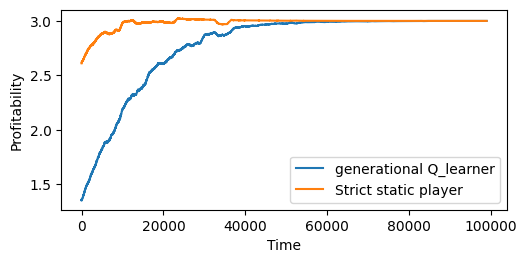

In [12]:

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Strict static player')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [14]:
np.shape(rewards_p1)

(50, 99998)

In [22]:
first_tenp1 = rewards_p1[0:10,:]
first_tenp2 = rewards_p2[0:10,:]

last_tenp1 = rewards_p1[-10:,:]
last_tenp2 = rewards_p2[-10:,:]

In [23]:
first_prof1, first_prof2 = prof_means(first_tenp1, first_tenp2)
last_prof1, last_prof2 = prof_means(last_tenp1, last_tenp2)

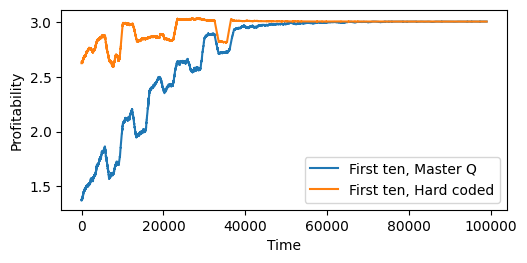

In [32]:

#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)
profitability_first1, profitability_first2 = moving_avg(first_prof1, first_prof2, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1,'-',label='First ten, Master Q')
plt.plot(t_arr2,profitability_first2,'-', label='First ten, Hard coded')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

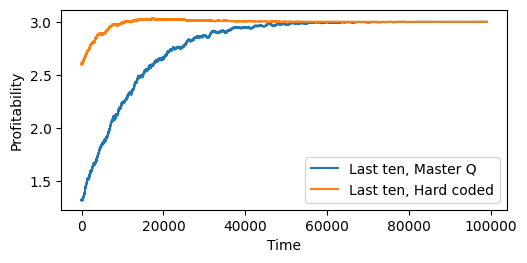

In [31]:
profitability_last1, profitability_last2 = moving_avg(last_prof1, last_prof2, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1,'-',label='Last ten, Master Q')
plt.plot(t_arr2,profitability_last2,'-', label='Last ten, Hard coded')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [33]:
first_fivep1 = rewards_p1[0:5,:]
first_fivep2 = rewards_p2[0:5,:]

last_fivep1 = rewards_p1[-5:,:]
last_fivep2 = rewards_p2[-5:,:]

In [35]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

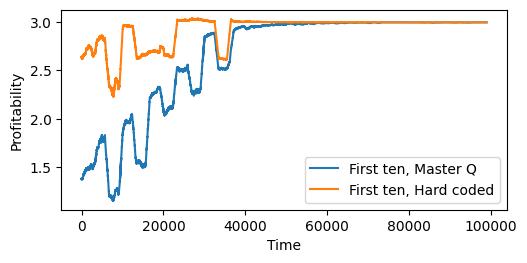

In [36]:
profitability_first1_5, profitability_first2_5 = moving_avg(first_prof1_5, first_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_first1_5,'-',label='First ten, Master Q')
plt.plot(t_arr2,profitability_first2_5,'-', label='First ten, Hard coded')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

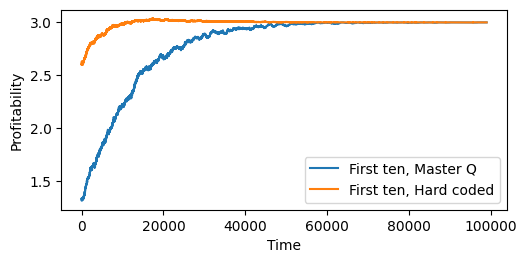

In [37]:
profitability_last1_5, profitability_last2_5 = moving_avg(last_prof1_5, last_prof2_5, 1000)
t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_last1_5,'-',label='First ten, Master Q')
plt.plot(t_arr2,profitability_last2_5,'-', label='First ten, Hard coded')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [34]:
first_prof1_5, first_prof2_5 = prof_means(first_fivep1, first_fivep2)
last_prof1_5, last_prof2_5 = prof_means(last_fivep1, last_fivep2)

In [40]:
options = np.array([0,1])
init_Q = np.zeros((15,2,2))
rewards_p1, rewards_p2, avg_prof, avg_prof2, final_Q2 = many_games(options, 100000, 0.3, 0.0000922, 50 ,0.95, final_Q)
final_Q

run # 1 of  50 runs
interval 6666.666666666667
run # 2 of  50 runs
interval 6666.666666666667
run # 3 of  50 runs
interval 6666.666666666667
run # 4 of  50 runs
interval 6666.666666666667
run # 5 of  50 runs
interval 6666.666666666667
run # 6 of  50 runs
interval 6666.666666666667
run # 7 of  50 runs
interval 6666.666666666667
run # 8 of  50 runs
interval 6666.666666666667
run # 9 of  50 runs
interval 6666.666666666667
run # 10 of  50 runs
interval 6666.666666666667
run # 11 of  50 runs
interval 6666.666666666667
run # 12 of  50 runs
interval 6666.666666666667
run # 13 of  50 runs
interval 6666.666666666667
run # 14 of  50 runs
interval 6666.666666666667
run # 15 of  50 runs
interval 6666.666666666667
run # 16 of  50 runs
interval 6666.666666666667
run # 17 of  50 runs
interval 6666.666666666667
run # 18 of  50 runs
interval 6666.666666666667
run # 19 of  50 runs
interval 6666.666666666667
run # 20 of  50 runs
interval 6666.666666666667
run # 21 of  50 runs
interval 6666.666666666667
r

array([[[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]],

       [[nan, nan],
        [nan, nan]]])

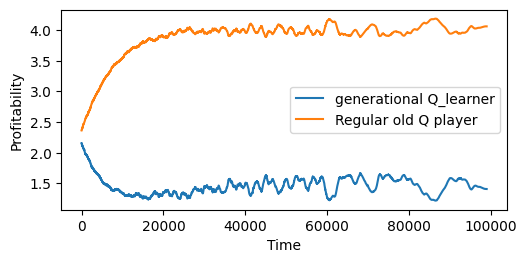

In [41]:
samlet_prof, samlet_prof2 = prof_means(rewards_p1, rewards_p2)

profitability_arr, profitability_arr2 = moving_avg(samlet_prof, samlet_prof2, 1000)
avg_timend = time.time()
#print('ending moving average. time: ', (avg_timend - avgtime))
#np.savetxt("<file>.csv", moving_averages, delimiter = ',')
#print(moving_averages)

t_arr1 = np.arange(0,98999)
t_arr2 = np.arange(0,98999)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,profitability_arr,'-',label='generational Q_learner')
plt.plot(t_arr2,profitability_arr2,'-', label='Regular old Q player')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [262]:

Q = np.zeros((10,2,2))

all_choices1, all_choices2, reward_arr, reward_arr_p2, q_table = PD_game(Q, options, 10000, 0.3, 0.000322, 0.95)



interval 1000.0
time for q 0 prev time for q 0 prev [[0 0]
 [0 0]]
PD_reward (3, 3)
argmax i Q 0.0
PREV 0
New Q est 5.85
operation 0.003
time for q 0 prev time for q 0 prev [[0 0]
 [0 0]]
PD_reward (3, 3)
argmax i Q 0.8827649999999999
PREV 0
New Q est 6.6466954125
operation 0.005
time for q 0 prev time for q 0 prev [[1 1]
 [0 0]]
PD_reward (5, 0)
argmax i Q 1.7560004574937498
PREV 1
New Q est 11.33479041288811
operation 0.007
time for q 0 prev time for q 0 prev [[0 0]
 [0 1]]
PD_reward (3, 3)
argmax i Q 0.0
PREV 0
New Q est 3.0
operation 0.009
time for q 0 prev time for q 0 prev [[0 0]
 [1 1]]
PD_reward (0, 5)
argmax i Q 0.0
PREV 0
New Q est 0.0
operation 0.011
time for q 0 prev time for q 0 prev [[0 0]
 [1 0]]
PD_reward (0, 5)
argmax i Q 1.945959187634454
PREV 0
New Q est 4.606228166840094
operation 0.013
time for q 0 prev time for q 0 prev [[0 0]
 [0 1]]
PD_reward (3, 3)
argmax i Q 0.7088985148766905
PREV 0
New Q est 3.639780909676213
operation 0.015
time for q 0 prev time for q 0 pr

In [151]:
avg_prof_arr, avg_prof_arr2 = moving_avg(reward_arr, reward_arr_p2, 100)
print(avg_prof_arr, avg_prof_arr2)

[1.42, 1.39, 1.36, 1.33, 1.33, 1.35, 1.33, 1.31, 1.29, 1.27, 1.25, 1.22, 1.19, 1.16, 1.16, 1.14, 1.16, 1.19, 1.22, 1.27, 1.25, 1.2, 1.19, 1.2, 1.21, 1.2, 1.19, 1.19, 1.19, 1.18, 1.17, 1.16, 1.18, 1.21, 1.24, 1.27, 1.27, 1.25, 1.27, 1.3, 1.33, 1.35, 1.37, 1.42, 1.43, 1.44, 1.42, 1.38, 1.38, 1.39, 1.4, 1.39, 1.38, 1.38, 1.41, 1.44, 1.44, 1.42, 1.44, 1.46, 1.48, 1.53, 1.54, 1.54, 1.54, 1.53, 1.52, 1.51, 1.53, 1.57, 1.57, 1.57, 1.57, 1.57, 1.57, 1.58, 1.56, 1.54, 1.52, 1.47, 1.46, 1.46, 1.49, 1.52, 1.52, 1.5, 1.52, 1.54, 1.56, 1.58, 1.6, 1.64, 1.64, 1.65, 1.66, 1.65, 1.64, 1.64, 1.67, 1.71, 1.71, 1.71, 1.71, 1.71, 1.71, 1.71, 1.71, 1.71, 1.71, 1.7, 1.69, 1.7, 1.71, 1.71, 1.68, 1.65, 1.65, 1.65, 1.65, 1.63, 1.65, 1.68, 1.71, 1.75, 1.75, 1.76, 1.77, 1.76, 1.75, 1.76, 1.77, 1.77, 1.74, 1.72, 1.7, 1.67, 1.64, 1.61, 1.61, 1.63, 1.61, 1.58, 1.55, 1.5, 1.52, 1.56, 1.56, 1.55, 1.54, 1.54, 1.54, 1.54, 1.54, 1.55, 1.53, 1.5, 1.47, 1.44, 1.44, 1.46, 1.44, 1.39, 1.38, 1.37, 1.39, 1.42, 1.45, 1.48, 1.4

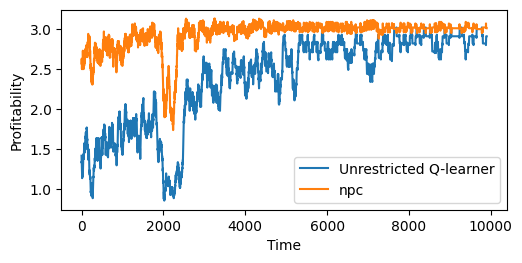

In [152]:
t_arr1 = np.arange(0,9899)
t_arr2 = np.arange(0,9899)
fig, ax = plt.subplots(figsize =(5.75, 2.6))
plt.plot(t_arr1,avg_prof_arr,'-',label='master Q-learner')
plt.plot(t_arr2,avg_prof_arr2,'-', label='npc')
#plt.axhline(y=0.125, color='k', linestyle = '--')
#plt.axhline(y=0.061, color='k', linestyle = '--')
plt.xlabel("Time")
plt.ylabel("Profitability")
#plt.ylim(0.00,0.15)
plt.legend()
plt.show()

In [153]:
print(q_table)

[[[57.35559155 49.68219822]
  [49.45033704 44.96957695]]

 [[59.26335598 51.20626294]
  [51.24626038 44.64644842]]

 [[58.47423078 50.04574614]
  [51.8176584  45.54847447]]

 [[59.99624021 52.24496549]
  [53.63757278 49.00137198]]

 [[59.99703501 51.25042288]
  [53.25368767 46.03836251]]

 [[59.99965025 52.60325636]
  [53.57067288 34.55339709]]

 [[59.99976919 53.34398141]
  [53.95861287 25.41013786]]

 [[59.99977594 52.74448515]
  [51.97470315 38.71796152]]

 [[59.99991334 52.93597702]
  [51.39548169 13.32537593]]

 [[59.99994281 52.21031014]
  [47.49132894  0.        ]]]
